In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import h5py
import shap

In [2]:
print("h5py version:", h5py.__version__)
print("SHAP version:", shap.__version__)
print("PyTorch version:", torch.__version__)

h5py version: 3.11.0
SHAP version: 0.39.0
PyTorch version: 2.3.1


In [3]:
params = {'batch_size': 128,
          'epochs': 100,
          'early_stop': 10,
          'lr': 0.002,
          'n_conv_layer': 4,
          'num_filters1': 256,
          'num_filters2': 60,
          'num_filters3': 60, 
          'num_filters4': 120,
          'kernel_size1': 7,
          'kernel_size2': 3,
          'kernel_size3': 5,
          'kernel_size4': 3,
          'n_dense_layer': 2,
          'dense_neurons1': 256,
          'dense_neurons2': 256,
          'dropout_conv': 'no',
          'dropout_prob': 0.4,
          'pad':'same'}

In [4]:
import pytorch_lightning as pl
from torch import nn

In [5]:
class DeepSTARR(pl.LightningModule):
    def __init__(self, params):
        super().__init__()
        
        self.params = params

        self.avgpool = nn.AvgPool1d(2)
        self.conv_dropout = nn.Dropout(p=0.1)
    
        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv1d(4, 256, kernel_size=7, padding=params['pad']),
            nn.BatchNorm1d(256),
            nn.LeakyReLU()
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv1d(256, 64, kernel_size=3, padding=params['pad'], dilation=2),
            nn.BatchNorm1d(64),
            nn.LeakyReLU()
        )

        # Third convolutional layer
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=5, padding=params['pad'], dilation=4),
            nn.BatchNorm1d(64),
            nn.LeakyReLU()
        )

        # Four convolutional layer
        self.conv4 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, padding=params['pad'], dilation=8),
            nn.BatchNorm1d(64),
            nn.LeakyReLU()
        )

        self.conv5 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, padding=params['pad'], dilation=16),
            nn.BatchNorm1d(64),
            nn.LeakyReLU()
        )

        
        # Fully connected layers
        fc_layers = []
        in_features = self._get_conv_output_shape((1, 4, 1001))
        for i in range(params['n_dense_layer']):
            out_features = params['dense_neurons'+str(i+1)]
            fc_layers.append(nn.Linear(in_features, out_features))
            fc_layers.append(nn.BatchNorm1d(out_features))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(params['dropout_prob']))
            in_features = out_features
        
        fc_layers.append(nn.Linear(in_features, 1))  # Final output layer
        self.fc = nn.Sequential(*fc_layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + self.conv3(x)
        x = self.conv_dropout(x)
        x = x + self.conv4(x)
        x = self.conv_dropout(x)
        x = self.avgpool(x)
        x = x + self.conv5(x)
        x = self.avgpool(x)
            
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc(x)
        
        return x

    def _get_conv_output_shape(self, shape):
        x = torch.rand(*shape)
        
        # mimic the convolution forward part
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = self.conv5(x)
        x = self.avgpool(x)
            
        return x.data.view(1, -1).size(1)
    
    def predict(self, x):
        return self.forward(x)

In [6]:
# model_path = './checkpoints/Residual_dilated_DeepSTARR_mesoderm.ckpt' # best model
# model_path = './checkpoints/Residual_dilated_DeepSTARR_visceral.ckpt' # best model
# model_path = './checkpoints/Residual_dilated_DeepSTARR_cardiac.ckpt' # best model
model_path = './checkpoints/Residual_dilated_DeepSTARR_somatic.ckpt' # best model
model = DeepSTARR.load_from_checkpoint(model_path, params=params).cpu()
model.eval()

DeepSTARR(
  (avgpool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv_dropout): Dropout(p=0.1, inplace=False)
  (conv1): Sequential(
    (0): Conv1d(4, 256, kernel_size=(7,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Sequential(
    (0): Conv1d(256, 64, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, dilation=(4,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv4): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, dilation=(8,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=Tr

In [7]:
X_test = joblib.load('./data/test/X_test')

In [8]:
np.random.seed(seed=1234)
# background = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)].astype(np.float32).transpose(0, 2, 1)
background = X_test[np.random.choice(X_test.shape[0], 500, replace=False)].astype(np.float32).transpose(0, 2, 1)
background = torch.tensor(background)
del X_test

In [9]:
print(model.device)
print(next(model.parameters()).is_cuda)
print(background.is_cuda)

cpu
False
False


In [10]:
explainer_score = shap.DeepExplainer(model, background)

In [11]:
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_data_meso')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_data_visc')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_data_card')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_data_soma')
# cand_test_data = joblib.load('./data/data_motifs_detection/global_data_meso')
# cand_test_data = joblib.load('./data/data_motifs_detection/global_data_visc')
# cand_test_data = joblib.load('./data/data_motifs_detection/global_data_card')
# cand_test_data = joblib.load('./data/data_motifs_detection/global_data_soma')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_1.3/diff_data_meso')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_1.3/diff_data_visc')
# cand_test_data = joblib.load('./data/data_motifs_detection/diff_1.3/diff_data_card')
cand_test_data = joblib.load('./data/data_motifs_detection/diff_1.3/diff_data_soma')

# sort by strength to have the stongest on top for later plotting
# cand_test_data = cand_test_data.sort_values(by='S2_mesoderm_log2', ascending = False)
# cand_test_data = cand_test_data.sort_values(by='S2_visceral_log2', ascending = False)
# cand_test_data = cand_test_data.sort_values(by='S2_cardiac_log2', ascending = False)
cand_test_data = cand_test_data.sort_values(by='S2_somatic_log2', ascending = False)
print(len(cand_test_data))
cand_test_data.head(20)

300


,seqnames,start,end,name,strand,S2_cardiac_log2,S2_fat_body_log2,S2_hemocytes_log2,S2_mesoderm_log2,S2_neuro_log2,S2_somatic_log2,S2_visceral_log2,Sequence,Class,split_flag
112388,chr2R,24309051,24310051,chr2R_24309051_24310051,+,6.802762,7.075201,6.053120,5.894585,7.304557,7.630238,7.240591,CCAATTAAATTTGATGATCTTGCTAAGATTGCAGTTGCCTGAGATT...,positive,Test
111482,chr2R,23935551,23936551,chr2R_23935551_23936551,+,6.097444,5.991152,6.194229,5.878281,6.353232,7.537079,6.731631,AGTTGTTGCAGAAAATCAACAAAACTTACAATTATTATTCCTAGCA...,positive,Test
107339,chr2R,22120051,22121051,chr2R_22120051_22121051,+,6.565143,5.779696,5.547444,5.841374,6.779207,7.536084,6.768251,AACTATGAGTCACCGGGGCACCGAGGAAGCGAAAGCCCTCGGCATG...,positive,Test
86508,chr2R,12924001,12925001,chr2R_12924001_12925001,+,5.844597,5.583417,6.239348,5.764837,6.496256,7.530118,6.571800,CCTCACATTGCGTCCACTTGGCGGCGGGTCCCTCGCAATTCACCGT...,positive,Test
99806,chr2R,18798901,18799901,chr2R_18798901_18799901,+,6.336623,6.851524,6.964768,5.904944,6.703724,7.469324,6.820996,AAACCTCAAAAACCACATAGTATGTGTATGTGATTTAATGTAATAT...,positive,Test
107321,chr2R,22111501,22112501,chr2R_22111501_22112501,+,6.518326,5.454979,5.281828,5.360238,5.516838,7.334059,6.726000,GTTGGCTGACTGCGATGGGACAGAAACGGAGAAGAATGGATGGATT...,positive,Test
112370,chr2R,24304401,24305401,chr2R_24304401_24305401,+,6.828860,6.456072,5.591961,6.378947,7.100967,7.262020,6.627551,GGAGCAGAAGTCCGAGCCCGATCTTCCTCCCCACTTAGGCCTGCTC...,positive,Test
96314,chr2R,17263601,17264601,chr2R_17263601_17264601,+,5.854080,5.671254,5.255924,5.290811,5.884935,7.261587,6.694936,TGCTTCATCCACGCTTACCACTCCTTCAGTTCGCGATTGTAATTCA...,positive,Test
103288,chr2R,20274001,20275001,chr2R_20274001_20275001,+,6.365939,6.818518,7.168752,6.507422,6.578866,7.214319,6.650018,TGGTACCAAATTCGTAGGACTCGTTGGAGACGCCCATCAGTGAGAT...,positive,Test
102738,chr2R,20067101,20068101,chr2R_20067101_20068101,+,4.852398,5.416752,4.767390,5.109494,5.989439,7.193486,6.149473,GCCGCATCTGAAGGGGGGCTCCCAGCCACGAACTCCCATCTTCCAT...,positive,Test


In [12]:
nucleotide_dict = {'A': [1, 0, 0, 0],
                   'C': [0, 1, 0, 0],
                   'G': [0, 0, 1, 0],
                   'T': [0, 0, 0, 1],
                   'N': [0, 0, 0, 0]} # sometimes there are Ns

# define a function to one-hot encode a single DNA sequence
def one_hot_encode(seq):
    return np.array([nucleotide_dict[nuc] for nuc in seq])

# function to load sequences and enhancer activity
def prepare_input(data_set):

  # one-hot encode DNA sequences, apply function
  seq_matrix = np.array(data_set['Sequence'].apply(one_hot_encode).tolist())

  return seq_matrix

In [13]:
slice_cand_test_data = cand_test_data
slice_X_cand_test = prepare_input(slice_cand_test_data)
slice_X_cand_test = slice_X_cand_test.astype(np.float32).transpose(0, 2, 1)
slice_X_cand_test = torch.tensor(slice_X_cand_test)
print(slice_X_cand_test.shape)

slice_pred_values = model.predict(slice_X_cand_test)
print(slice_pred_values.shape)

torch.Size([300, 4, 1001])
torch.Size([300, 1])


In [14]:
slice_shap_values = explainer_score.shap_values(slice_X_cand_test)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [15]:
slice_X_cand_test = slice_X_cand_test.numpy().transpose(0, 2, 1)
slice_shap_values = slice_shap_values.transpose(0, 2, 1)

In [16]:
print(slice_X_cand_test.shape)
print(slice_shap_values.shape)

(300, 1001, 4)
(300, 1001, 4)


In [17]:
slice_final_contr_scores = slice_shap_values * slice_X_cand_test
print(slice_final_contr_scores.shape)
print(slice_cand_test_data.iloc[0]['Sequence'][:6]) # check DNA sequence
print(slice_final_contr_scores[0,:6])

(300, 1001, 4)
CCAATT
[[-0.00000000e+00  2.95263104e-04  0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00 -6.66818931e-04  0.00000000e+00 -0.00000000e+00]
 [-3.05950642e-04  0.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 3.19125800e-04 -0.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00 -5.95546153e-04]
 [-0.00000000e+00  0.00000000e+00  0.00000000e+00  6.27938862e-05]]


In [18]:
import deeplift
from deeplift.visualization import viz_sequence # function from https://github.com/kundajelab/deeplift/blob/671ee67a03bd5bebf4c405af59eec45d3ca2a288/deeplift/visualization/viz_sequence.py

Enhancer: chr2R_24309051_24310051
Obs act: 7.63
Pred act: 6.27
Actual contribution scores


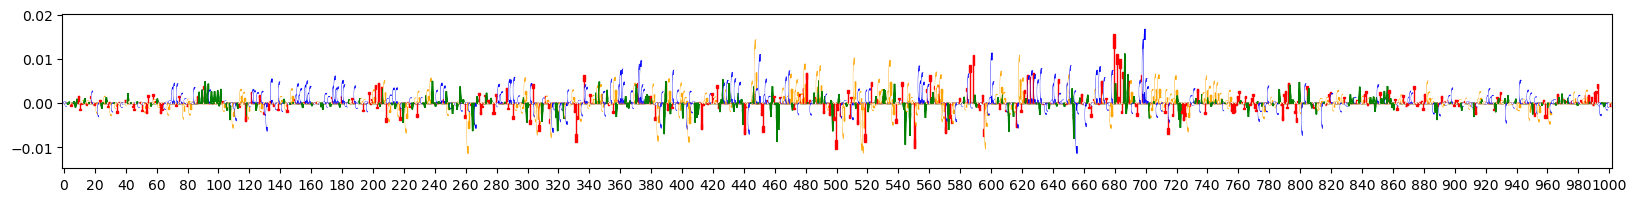

Enhancer: chr2R_23935551_23936551
Obs act: 7.54
Pred act: 5.80
Actual contribution scores


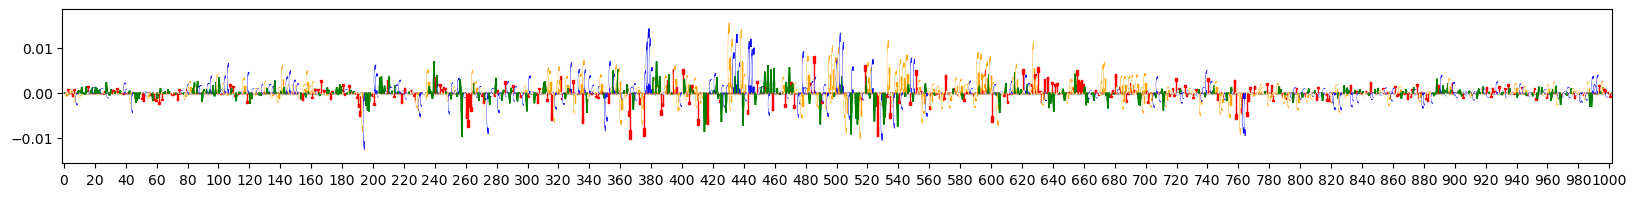

Enhancer: chr2R_22120051_22121051
Obs act: 7.54
Pred act: 5.64
Actual contribution scores


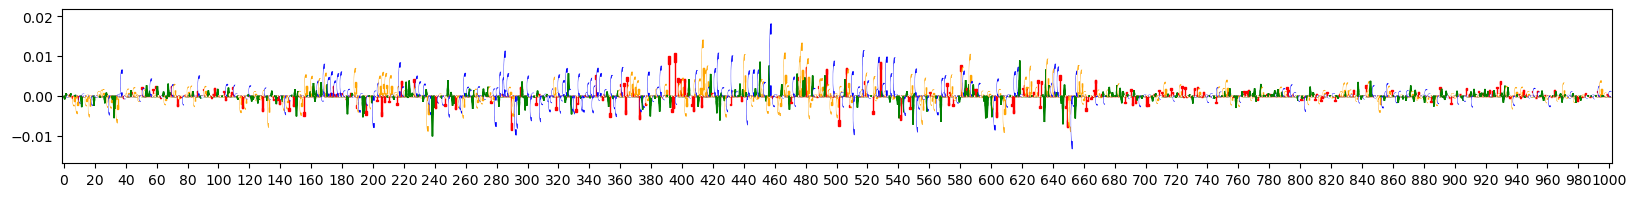

Enhancer: chr2R_12924001_12925001
Obs act: 7.53
Pred act: 5.38
Actual contribution scores


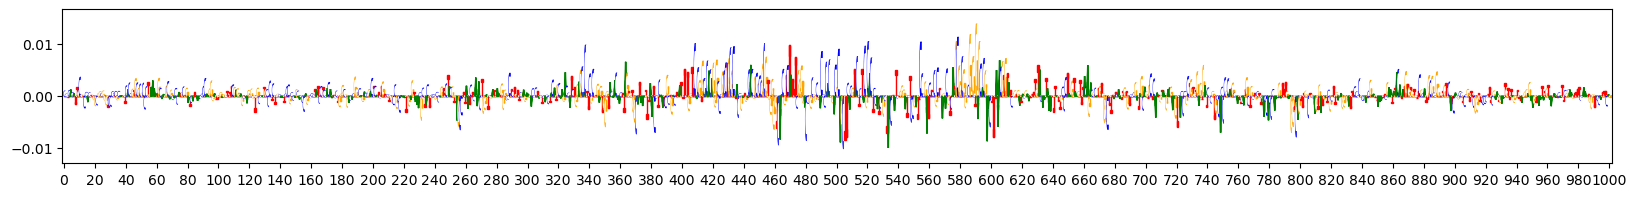

Enhancer: chr2R_18798901_18799901
Obs act: 7.47
Pred act: 6.24
Actual contribution scores


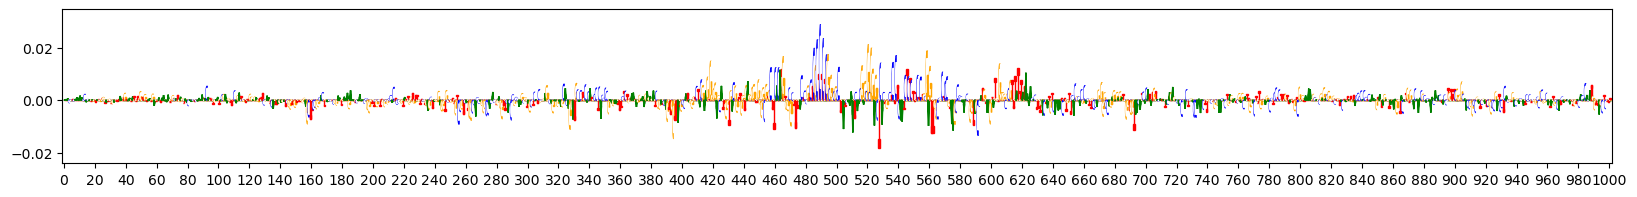

In [19]:
for i in range(5):
    print('Enhancer:', slice_cand_test_data.iloc[i]['name'])
    print('Obs act:', '{0:0.2f}'.format(slice_cand_test_data.iloc[i]['S2_somatic_log2']))
    print('Pred act:', '{0:0.2f}'.format(slice_pred_values[i][0]))
    print('Actual contribution scores')
    viz_sequence.plot_weights(slice_final_contr_scores[i], figsize=(20,2), subticks_frequency=20)

    # print('Hypothetical contribution scores')
    # viz_sequence.plot_weights(shap_values_dev[i], figsize=(20,2), subticks_frequency=20)

In [20]:
print(slice_final_contr_scores.shape)
print(slice_shap_values.shape)
print(len(slice_cand_test_data))
print(slice_X_cand_test.shape)

(300, 1001, 4)
(300, 1001, 4)
300
(300, 1001, 4)


In [21]:
import os

out = './contribution_scores/somatic/diff_1.3/BestModel_contr_scores_somatic.h5'  
f = h5py.File(out, 'w')

# save the actual contribution scores
g = f.create_group("actual_contrib_scores")
g.create_dataset('Contrib_scores', data=slice_final_contr_scores)

# save the hypothetical contribution scores
g = f.create_group("hyp_contrib_scores")
g.create_dataset('Contrib_scores', data=slice_shap_values)

g = f.create_group("onehot_samples")
g.create_dataset('cand_x', data=slice_X_cand_test)

f.close()


In [22]:
joblib.dump(slice_cand_test_data, './contribution_scores/somatic/diff_1.3/cand_test_data_somatic')

['./contribution_scores/somatic/diff_1.3/cand_test_data_somatic']